# Now Insurance Loss Runs #
## automatic extraction of relevant information in loss reports from pdf files ##

In [1]:
## load depedencies 
import lossrun
import Lossrun_models # ORM models
import matplotlib.pyplot as plt
import datetime

2020-09-23 16:45:35,722 INFO sqlalchemy.engine.base.Engine select version()
2020-09-23 16:45:35,723 INFO sqlalchemy.engine.base.Engine {}
2020-09-23 16:45:35,726 INFO sqlalchemy.engine.base.Engine select current_schema()
2020-09-23 16:45:35,727 INFO sqlalchemy.engine.base.Engine {}
2020-09-23 16:45:35,730 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2020-09-23 16:45:35,731 INFO sqlalchemy.engine.base.Engine {}
2020-09-23 16:45:35,734 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2020-09-23 16:45:35,735 INFO sqlalchemy.engine.base.Engine {}
2020-09-23 16:45:35,736 INFO sqlalchemy.engine.base.Engine show standard_conforming_strings
2020-09-23 16:45:35,737 INFO sqlalchemy.engine.base.Engine {}
2020-09-23 16:45:35,738 INFO sqlalchemy.engine.base.Engine select relname from pg_class c join pg_namespace n on n.oid=c.relnamespace where pg_catalog.pg_table_is_visible(c.oid) and relname=%(name)s
20

## Pre-processing ##

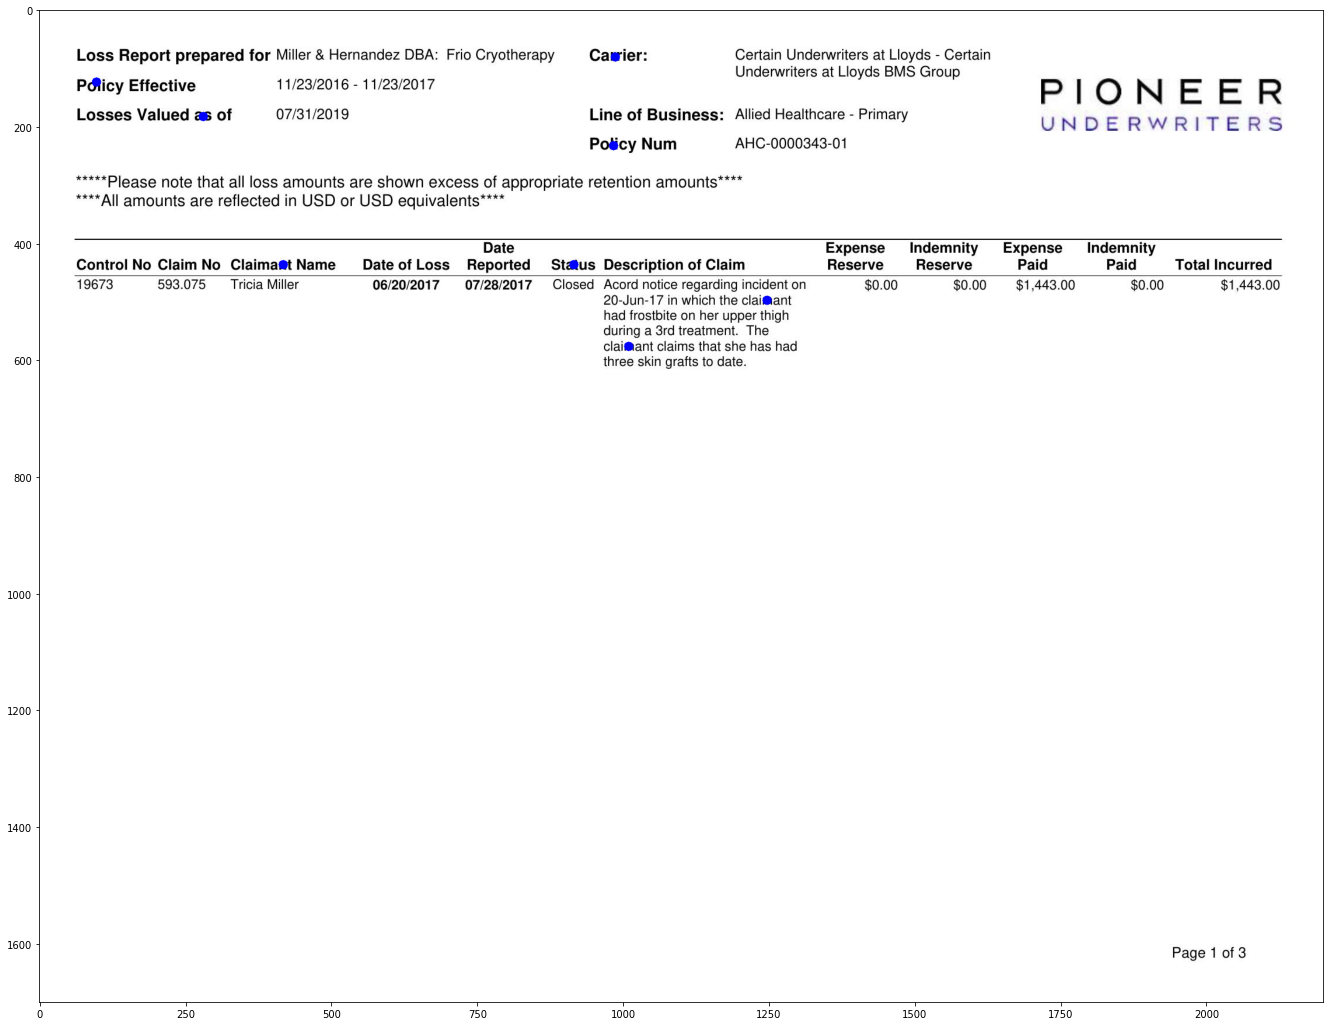

In [72]:
## Select file


# pdf raw file no ext 
#__________________________________________
#pdf_file = 'B00319X_Dr. Majoch loss run MAG-YES0'
#___________________________________________

#__________________________________________
pdf_file = 'AHC-0000343 loss runs PIO-YES0'
#___________________________________________

#__________________________________________
#pdf_file = 'Acts Home care loss runs PIO-NO1'
#___________________________________________


#__________________________________________
#pdf_file = 'Acts Home Pioneer loss runs PIO-NO1'
#___________________________________________

# topic files
topic_file = 'config_topics_beta.ino'
# Pre proc data
txt_dict, image_c, image, topics = lossrun.pre_proc(pdf_file, 'data', topic_file)

# vizualizate data
plt.figure(figsize=(23,20))
# Orignial data
plt.imshow(image_c)
# Orignial data

## Spatial relation filter ##

In [73]:
## load topics

# search topics in data pre - proc
spatial_filter = lossrun.spatial_filter(txt_dict, topics)
spatial_filter_topics = len(spatial_filter)

for topic in range(spatial_filter_topics):
# data ver
    print('SEARCHING TOPIC: ' + topics[topic][0])
    print('In: ' + ' '.join(spatial_filter[topic]) )
    print('.'*100 + '\n')

SEARCHING TOPIC: insurer
In: i Line of  Policy Num retention Status Description Closed Acord notice    20-Jun-17  had frostbite  during a  claimant  three skin Certain Underwriters at Lloyds - Certain  Underwriters at Lloyds BMS Group
....................................................................................................

SEARCHING TOPIC: policy_num
In:    Losses    *“*Please  ****All              Control  19673    Loss Report prepared for Miller & Hernandez DBA: Frio Cryotherapy Carrier: Certain Underwriters at Lloyds - Certain  Underwriters at Lloyds BMS Group Effective 11/23/2016 - 11/23/2017 PIONEER
....................................................................................................

SEARCHING TOPIC: policy_num
In: retention Status Description Closed Acord    20-Jun-17  had frostbite  during  claimant  three Num AHC-0000343-01
....................................................................................................

SEARCHING TOPIC: claimant


## Name entity recognition ##

In [68]:
def encuentra(tupleT,busqueda):
    for i in range (len(tupleT)):
        if tupleT[i][1] == busqueda:
            return i

In [49]:
## LOAD NAME MODEL 
import spacy 
# load UBM NER model
nlp = spacy.load('en_core_web_sm')

# load custom NER model
#nlp = spacy.load('./data/results/models/')

In [76]:

from configobj import ConfigObj

# topic rules
ner_rules = ConfigObj('config_rules_beta.ino')

_temp = []
#
for i in range(len(spatial_filter)):

    string = ' '.join(spatial_filter[:][i])
    doc = nlp(string)
    #displacy.serve(doc, style= 'ent')
    for j in range(len(ner_rules[topics[i][0]])):
        
        for ent in doc.ents:
            
            if ent.label_ in ner_rules[topics[i][0]]:
                print(topics[i][0], ent.text, ner_rules[topics[i][0]], ent.label_)
                _temp += [(ent.text,ent.label_)] 

            #print()
        #
_temp = list(dict.fromkeys(_temp))
#print(len(_temp))
#print(_temp)
#print(encuentra(_temp,'PERSON'))

insurer Lloyds BMS Group ['ORG'] ORG
policy_num 20-Jun-17 ['CARDINAL'] CARDINAL
policy_num three ['CARDINAL'] CARDINAL
claimant Tricia Miller ['PERSON', 'ORG'] PERSON
claimant Tricia Miller ['PERSON', 'ORG'] PERSON
report_date 7/31/2014 ['DATE'] DATE


## DATA BASE INSERTION ##

In [75]:
#Sinlge function for database insertion
Lossrun_models.registerRecord(timeDimDay = 12,
                              timeDimMonth = 9,
                              timeDimYear = 20,
                              policyDimStatus = "Open", 
                              reportGeneratorDimName = _temp[encuentra(_temp,'ORG')][0], 
                              insuredDimName = _temp[encuentra(_temp,'ORG')][0],
                              insurerDimName = _temp[encuentra(_temp,'PERSON')][0], 
                              statusName = "Open", 
                              lossRunReportDimDate = datetime.datetime.now()) 

2020-09-23 17:09:44,123 INFO sqlalchemy.engine.base.Engine BEGIN (implicit)
2020-09-23 17:09:44,125 INFO sqlalchemy.engine.base.Engine INSERT INTO time_dim (day, month, year) VALUES (%(day)s, %(month)s, %(year)s) RETURNING time_dim.timeid
2020-09-23 17:09:44,125 INFO sqlalchemy.engine.base.Engine {'day': 12, 'month': 9, 'year': 20}
2020-09-23 17:09:44,128 INFO sqlalchemy.engine.base.Engine INSERT INTO status_dim (status_name) VALUES (%(status_name)s) RETURNING status_dim.status_id
2020-09-23 17:09:44,129 INFO sqlalchemy.engine.base.Engine {'status_name': 'Open'}
2020-09-23 17:09:44,131 INFO sqlalchemy.engine.base.Engine INSERT INTO insurer_dim (insurer_name, insurer_address, insurer_status) VALUES (%(insurer_name)s, %(insurer_address)s, %(insurer_status)s) RETURNING insurer_dim.insurer_id
2020-09-23 17:09:44,132 INFO sqlalchemy.engine.base.Engine {'insurer_name': 'Tricia Miller', 'insurer_address': None, 'insurer_status': None}
2020-09-23 17:09:44,134 INFO sqlalchemy.engine.base.Engine

## Contextual analysis

In [8]:
# Call the model 
model = lossrun.load_context_model()

In [9]:
model.most_similar('policy')

[('policies', 0.7645671367645264),
 ('polices', 0.630499005317688),
 ('Policy', 0.5976893901824951),
 ('strategy', 0.5257989764213562),
 ('Policies', 0.5219711065292358),
 ('pol_icy', 0.5131624341011047),
 ('stance', 0.49999743700027466),
 ('doctrine', 0.49668481945991516),
 ('regulations', 0.48280826210975647),
 ('laws', 0.47833386063575745)]

In [10]:
similar = []
try:
    similar.append(model.most_similar_to_given('ORG', txt_dict['text']))
except: 
    similar.append('0')

similar

['0']

In [11]:
# test cell ignore it
###############################


# check topic
_topic = 'insurer'

relates_words_index = []

rate_relation =  0.1 # where grammar  correlation goes to -1 to 1 

for i in txt_dict['text']:

    try:
        relates_words_index.append(model.similarity(_topic, i))
    except:
        relates_words_index.append(0)
#model.similarity()
for index, relate_rate in enumerate(relates_words_index):

    if (relate_rate > .2):
        #print(index)
        print(txt_dict['text'][index])

BANK
NPDB
Provider
INSURANCE
INSURER
